> Yuri Diego Santos Niitsuma

# Objetivo

O trabalho prático 2 consiste em utilizar técnicas de agrupamentos da segunda parte
do cronograma do curso. A proposta de objetivo do trabalho é agrupar documentos com
características similares, que assim espera-se ter como resultado uma classificação
automática dos documentos.

# Base de dados

A base de dados que será utilizada é a BBC News Articles, a mesma base de
dados do trabalho prático 1 https://www.kaggle.com/pariza/bbc-news-summary/home

Nesta base, consiste em publicações de artigos de notícias divididos em 5
categorias:

- Negócios (business)
- Entretenimento (entertainment)
- Política (politics)
- Esporte (sport)
- Tecnologia (tech)


# Metodologia

Os documentos serão misturados e após o processo de clusterização será verificada
se com alguns parâmetros se aproximará da divisão inicial ou se encontrará uma
característica nova da base de dados.

Em resumo iremos utilizar um classificador não supervisionado e verificaremos a acurácia do modelo comparando com a classe já rotulada.

In [1]:
import gensim
import numpy as np
import collections
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%pylab inline
# Para o PDF exportado conter as imagens vetorizadas
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import os
import pandas as pd

# model.save(fname)
# model = Doc2Vec.load(fname)  # you can continue training with the loaded model!
# model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

c:\users\ignit\local\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Leitura do dataset mantendo o texto original e separando em tokens

bbc_news_folder = 'BBC News Articles'

content = dict()

for article_class in os.listdir(bbc_news_folder):
    collections_articles = []
    for each_article in os.listdir(bbc_news_folder + '/' + article_class):
        article = ''
        with open(bbc_news_folder + '/' + article_class + '/' + each_article) as f:
            article = f.read()
            article_preprocess = gensim.utils.simple_preprocess(article, article_class)
            
        collections_articles.append((article, article_preprocess))
        
    content[article_class] = collections_articles

content.keys()

dict_keys(['business', 'entertainment', 'politics', 'sport', 'tech'])

In [3]:
dfs = []
dfs += [pd.DataFrame({'class': 'business', 'texts': [x for x, y in content['business']], 'tokens': [y for x, y in content['business']]})]
dfs += [pd.DataFrame({'class': 'entertainment', 'texts': [x for x, y in content['entertainment']], 'tokens': [y for x, y in content['entertainment']]})]
dfs += [pd.DataFrame({'class': 'politics', 'texts': [x for x, y in content['politics']], 'tokens': [y for x, y in content['politics']]})]
dfs += [pd.DataFrame({'class': 'sport', 'texts': [x for x, y in content['sport']], 'tokens': [y for x, y in content['sport']]})]
dfs += [pd.DataFrame({'class': 'tech', 'texts': [x for x, y in content['tech']], 'tokens': [y for x, y in content['tech']]})]
df = pd.concat(dfs)
df['class'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Como pode ver o texto original com tokens separados.

In [4]:
df.head()

,class,texts,tokens
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,"[ad, sales, boost, time, warner, profit, quart..."
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,"[dollar, gains, on, greenspan, speech, the, do..."
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,"[yukos, unit, buyer, faces, loan, claim, the, ..."
3,business,High fuel prices hit BA's profits\n\nBritish A...,"[high, fuel, prices, hit, ba, profits, british..."
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,"[pernod, takeover, talk, lifts, domecq, shares..."


In [5]:
# Contagem do total de documentos
df.drop(['texts', 'tokens'], axis=1).describe()

,class
count,2225
unique,5
top,sport
freq,511


In [6]:
# Contagem dos documentos de cada classe
df.groupby('class').count()

,texts,tokens
class,,
business,510,510
entertainment,386,386
politics,417,417
sport,511,511
tech,401,401


Aqui vamos converter no formato apropriado para o **Doc2Vec** do **gensim** e atrelando um identificador inteiro ao documento.

In [7]:
common_texts = df.drop('class', axis=1).values[:,:].tolist()
documents = [TaggedDocument(doc[1], [i]) for i, doc in enumerate(common_texts)]

# Segue um exemplo
documents[:1], len(documents)

([TaggedDocument(words=['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at', 'us', 'media', 'giant', 'timewarner', 'jumped', 'to', 'bn', 'for', 'the', 'three', 'months', 'to', 'december', 'from', 'year', 'earlier', 'the', 'firm', 'which', 'is', 'now', 'one', 'of', 'the', 'biggest', 'investors', 'in', 'google', 'benefited', 'from', 'sales', 'of', 'high', 'speed', 'internet', 'connections', 'and', 'higher', 'advert', 'sales', 'timewarner', 'said', 'fourth', 'quarter', 'sales', 'rose', 'to', 'bn', 'from', 'bn', 'its', 'profits', 'were', 'buoyed', 'by', 'one', 'off', 'gains', 'which', 'offset', 'profit', 'dip', 'at', 'warner', 'bros', 'and', 'less', 'users', 'for', 'aol', 'time', 'warner', 'said', 'on', 'friday', 'that', 'it', 'now', 'owns', 'of', 'search', 'engine', 'google', 'but', 'its', 'own', 'internet', 'business', 'aol', 'had', 'has', 'mixed', 'fortunes', 'it', 'lost', 'subscribers', 'in', 'the', 'fourth', 'quarter', 'profits', 'were', 'lower', 'than', '

## Treinamento do Word2Vec/Doc2Vec

Aqui ocorre o treinamento, que é feito o dicionário, o treinamento Word2vec junto com umvetor de parágrafo a cada documento (o que origina o Doc2Vec).

In [9]:
model = Doc2Vec(documents, vector_size=10, window=5, min_count=1, workers=4)

## Visualização do Word2vec

O Word2Vec também é treinado, por isso vamos verificar como as caracteríscas das palavras foram separadas

Vamos aplicar **Principal Component Analysis** (PCA) nos dados para termos uma melhor visualização em 2D.

In [10]:
pd_pca = pd.DataFrame(model.wv.vectors)
pd_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,0.746284,-1.895404,0.639263,0.129050,-0.779737,-0.483876,-2.520900,0.967141,2.349389,2.510942
1,-1.342392,-2.835912,-1.500311,0.165401,-1.402897,1.949757,-2.616969,-3.201666,2.729042,1.687927
2,-1.352580,-2.264777,-2.106140,-0.726866,-1.904965,1.314452,-1.146132,0.670837,1.582415,0.385896
3,-1.494995,-2.215339,-1.198648,-1.722846,-0.440692,1.233314,-0.240152,0.002466,0.982494,0.445491
4,-0.874936,-2.714905,-2.478933,1.043792,-2.259087,0.362907,-1.642790,2.266404,1.185789,0.045836


In [11]:
pd_pca.describe()

,0,1,2,3,4,5,6,7,8,9
count,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000
mean,-0.141045,-0.347293,-0.059662,-0.123928,0.072056,-0.068072,-0.211072,0.097775,0.241974,0.033236
std,0.331840,0.541753,0.284952,0.283331,0.246394,0.243886,0.462784,0.348309,0.424276,0.299360
min,-10.711040,-6.687672,-6.244360,-5.240916,-4.312929,-5.003855,-6.770142,-6.846777,-3.192148,-6.247730
25%,-0.128753,-0.369336,-0.063867,-0.145695,-0.003549,-0.072169,-0.177674,0.000155,0.034815,-0.034202
50%,-0.050770,-0.131785,-0.018697,-0.060419,0.033929,-0.025189,-0.065294,0.044105,0.090083,0.003523
75%,-0.010410,-0.057410,0.020280,-0.015242,0.082943,0.011371,-0.021409,0.111188,0.247971,0.042560
max,4.369030,0.525831,4.844619,4.627934,6.994373,5.005340,2.846500,5.732811,6.805396,7.179392


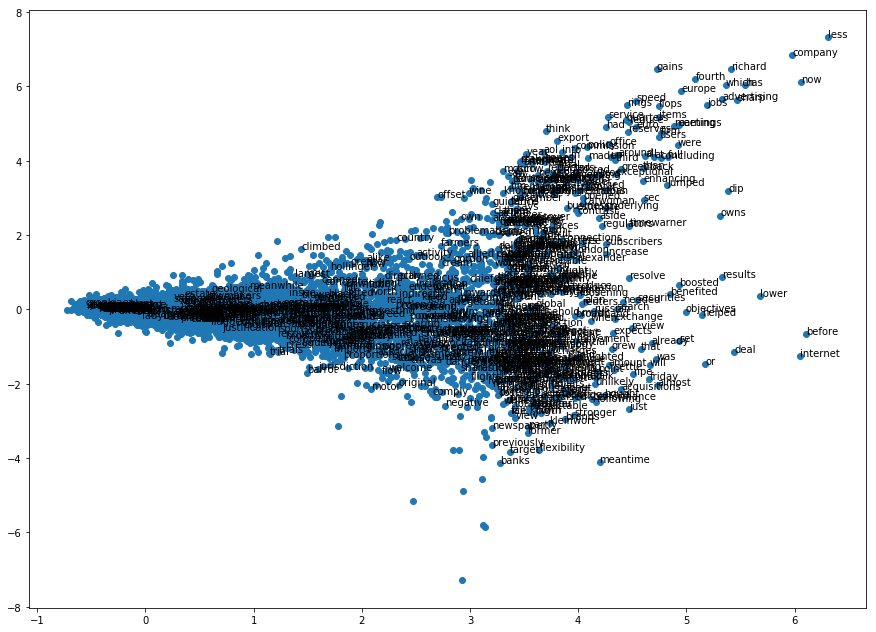

In [12]:
plt.figure(figsize=(15,11))
X_pca = PCA().fit_transform(model.wv.vectors)
plt.scatter(X_pca[:, 0], X_pca[:, 1]);

xv = list(zip(X_pca[:, :2].tolist(), model.wv.vocab))
np.random.shuffle(xv)

count_left = [0, 0, 0, 0]
for X, word in xv:
    if X[0] > 3.2:
        plt.text(X[0], X[1], word)
    elif X[0] > 2.2:
        if count_left[0] < 100:
            plt.text(X[0], X[1], word)
        count_left[0] += 1
    elif X[0] > 1.2:
        if count_left[1] < 100:
            plt.text(X[0], X[1], word)
        count_left[1] += 1
    elif X[0] > 0.2:
        if count_left[2] < 70:
            plt.text(X[0], X[1], word)
        count_left[2] += 1
    else:
        if count_left[3] < 30:
            plt.text(X[0], X[1], word)
        count_left[3] += 1

Como pode ver na figura, a separação ficou um pouco esquisita direcionado para uma direção apenas, isto pode ser ocasionado pela natureza dos dados, que são artigos de nóticas, tendo como resultados um texto estrutural ser bem semelhantes mesmo tratando de assuntos diferentes.

In [13]:
# Segue algumas palavras junto com suas palavras mais similares baseado no treinamento dos dados
for _ in range(5):
    word = np.random.choice(list(model.wv.vocab))
    print(word, model.most_similar(word))
    print()

oldham [('gritty', 0.9987844824790955), ('notably', 0.9970641732215881), ('mercedes', 0.9966791868209839), ('performing', 0.9962354302406311), ('adventure', 0.9952566027641296), ('israel', 0.9950686693191528), ('belgium', 0.995000958442688), ('breaks', 0.994335949420929), ('outdoor', 0.9939910769462585), ('fiction', 0.9936388731002808)]

shortstop [('conservatory', 0.983587384223938), ('holidaying', 0.9664992094039917), ('brace', 0.9643886685371399), ('bournemouth', 0.9586321115493774), ('clung', 0.9580440521240234), ('pernicious', 0.9561491012573242), ('nyse', 0.9536505937576294), ('warner', 0.9521655440330505), ('nikkei', 0.9513011574745178), ('comedic', 0.9512220621109009)]

sos [('lahore', 0.9766077399253845), ('irakli', 0.9718935489654541), ('lawlessness', 0.9655255079269409), ('chakrabarti', 0.9618129134178162), ('void', 0.9604010581970215), ('geary', 0.9581822156906128), ('template', 0.9580474495887756), ('tops', 0.9576382637023926), ('clinical', 0.9544863104820251), ('broadus',

c:\users\ignit\local\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
c:\users\ignit\local\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Doc2Vec

O modelo sendo uma extensão do Word2vec, faz com que cada documento possua um vetor de características também, quer dizer que posso plotar estes dados já certo?

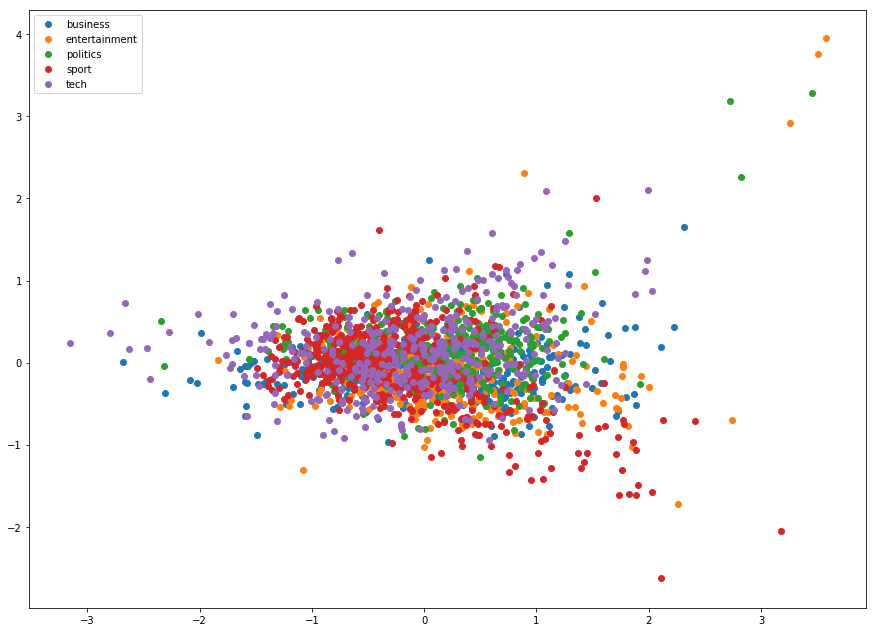

In [14]:
plt.figure(figsize=(15,11))
X_pca = PCA().fit_transform(model.docvecs.vectors_docs)

for cl in df['class'].unique():
    plt.scatter(X_pca[df['class'] == cl, 0], X_pca[df['class'] == cl, 1]);
plt.legend(list(df['class'].unique()));

**ERRADO**, na figura temos os vetores dos documentos mas eles foram treinados apenas localmente (junto com as palavras do seu documento). O que deve ser feito é inserir os vetores de um conjunto de palavras e através disto conserguimos inferir uma aproximação do vetor considerando uma parcela dos vetores de todos os documentos. 

In [15]:
# Exemplo de inferência utilizando 3 palavras
# o resultado pode ser diferente em cada execução devido ao processo de escolhas aleatórias no método
model.infer_vector(['playstation', 'launchs', 'day'])

array([-0.03873899, -0.10212461,  0.0575315 , -0.031223  , -0.01675905,
        0.00890428, -0.00165144,  0.01300101,  0.02103498,  0.014791  ],
      dtype=float32)

Esta função tem como objetivo colecionar os ranks dos documentos além de retornar os vetores dos documentos inferidos.

In [22]:
def get_ranks():
    ranks = []
    second_ranks = []
    vectors = []
    for doc_id in range(len(documents)):
        inferred_vector = model.infer_vector(documents[doc_id].words)
        vectors.append(inferred_vector)
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
        rank = [docid for docid, sim in sims].index(doc_id)
        ranks.append(rank)

        second_ranks.append(sims[1])
    
    return ranks, second_ranks, sims, vectors


In [23]:
ranks, second_ranks, sims, inferred_vectors = get_ranks() 

c:\users\ignit\local\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Agora com estes vetores gerados, vamos plotar no gráfico utilizando novamente PCA.

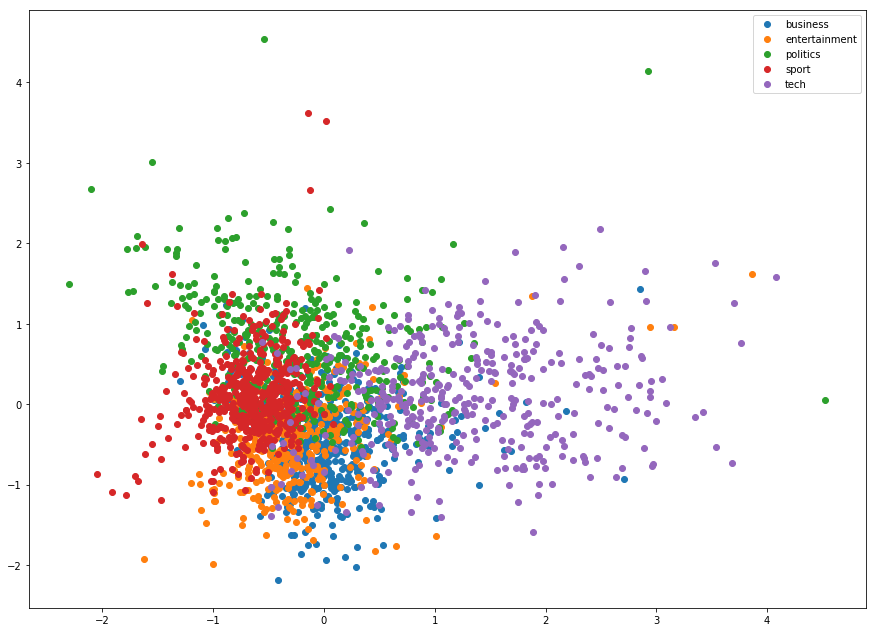

In [24]:
plt.figure(figsize=(15,11))
X_pca = PCA().fit_transform(np.array(inferred_vectors))

for cl in df['class'].unique():
    plt.scatter(X_pca[df['class'] == cl, 0], X_pca[df['class'] == cl, 1]);
plt.legend(list(df['class'].unique()));


Observe que os dados obtiveram uma melhora, nos vetores de tecnologia podemos ver que é mais disperso e é mais visualmente separado que os demais.

Mas os vetores ainda continuam juntos, podendo ser originado pela natureza dos textos ou pelo seu tamanho pequeno do dataset.

Como curiosidade, logo abaixo segue os tokens do documento 847 e seus documentos mais similares para o menos similar.

In [25]:
ranks[:5], second_ranks[:5]

([1158, 2207, 2152, 26, 36],
 [(5, 0.8904303908348083),
  (860, 0.910319983959198),
  (9, 0.8832553029060364),
  (5, 0.886909008026123),
  (1407, 0.9814224243164062)])

In [26]:
doc_id = 847
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(documents[doc_id].words[:50] + ['...'])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(documents[sims[index][0]].words[:50] + ['...'])))

Document (847): «howl helps boost japan cinemas japan box office received boost last year with ticket sales worth bn yen bn the surge was led by animated movie howl moving castle which took bn yen to become the biggest film in japan in it is expected to match the bn yen record ...»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d10,n5,w5,s0.001,t4):

MOST (2224, 0.9492841958999634): «losing yourself in online gaming online role playing games are time consuming but enthralling flights from reality but are some people taking their fantasy lives too seriously when video game world of warcraft hit the shops in europe last week fans wrote in to the bbc website to express their ...»

SECOND-MOST (862, 0.9084125757217407): «roundabout continues nostalgia trip the new big screen version of the magic roundabout released in the uk on friday is the latest attempt to turn children television into box office gold recent years have seen less than successful adaptation of the puppet show thunderbird

# Partindo para o lemonade

Vamos utilizar estes dados contendo os vetores inferidos dos documentos para utilizarmos um classificador na plataforma.

In [30]:
columns_name = []
for dim in range(np.array(inferred_vectors).shape[1]):
    columns_name += ['vec' + str(dim)]
    
df_vec = pd.DataFrame(inferred_vectors, columns=columns_name)
df_vec.head()

,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9
0,-0.275950,-0.698068,-0.728720,-0.170349,0.198916,-1.096274,0.233265,0.490869,1.488259,-0.036816
1,-0.443100,-0.278181,-0.393093,0.027804,0.170198,-0.026685,-0.061002,0.444486,1.110786,0.471515
2,0.213995,-0.556474,-0.041267,-0.587918,0.782657,-0.377334,-0.261711,0.513267,0.739844,-0.612369
3,-0.422849,-1.060201,-0.853710,0.333484,-0.074879,-0.697989,0.495332,0.614692,1.339561,0.651249
4,-0.779854,-1.490514,0.025766,-0.619233,0.610599,-0.278263,-0.094686,0.794718,1.418605,-0.079140


In [32]:
# Gravar os vetores para importar no Lemonade
output_data = pd.concat([pd.DataFrame(df['class'].values, columns=['class']), df_vec], axis=1)
output_data.to_csv('BBCNewsdoc2vec.csv')
output_data.head()

,class,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9
0,business,-0.275950,-0.698068,-0.728720,-0.170349,0.198916,-1.096274,0.233265,0.490869,1.488259,-0.036816
1,business,-0.443100,-0.278181,-0.393093,0.027804,0.170198,-0.026685,-0.061002,0.444486,1.110786,0.471515
2,business,0.213995,-0.556474,-0.041267,-0.587918,0.782657,-0.377334,-0.261711,0.513267,0.739844,-0.612369
3,business,-0.422849,-1.060201,-0.853710,0.333484,-0.074879,-0.697989,0.495332,0.614692,1.339561,0.651249
4,business,-0.779854,-1.490514,0.025766,-0.619233,0.610599,-0.278263,-0.094686,0.794718,1.418605,-0.079140


O Job **7332** no lemonade nos da os seguintes resultados:

![Lemonade Gaussian Example](img/LemonadeClustering.PNG)

| class         | prediction | count |
|---------------|------------|-------|
| business      | 0          | 142   |
| tech          | 0          | 85    |
| sport         | 0          | 66    |
| politics      | 0          | 39    |
| entertainment | 0          | 35    |
| entertainment | 1          | 144   |
| sport         | 1          | 137   |
| tech          | 1          | 11    |
| business      | 1          | 9     |
| politics      | 1          | 7     |
| sport         | 2          | 271   |
| business      | 2          | 258   |
| entertainment | 2          | 170   |
| politics      | 2          | 95    |
| tech          | 2          | 20    |
| politics      | 3          | 267   |
| tech          | 3          | 201   |
| business      | 3          | 97    |
| entertainment | 3          | 27    |
| sport         | 3          | 12    |
| tech          | 4          | 84    |
| sport         | 4          | 25    |
| entertainment | 4          | 10    |
| politics      | 4          | 9     |
| business      | 4          | 4     |

Os resultados foram muitos ruins no prediction com exceção do 4, pois a classe *tech* é mais fácil de ser separado e as outras classes são bem correlacionados.

In [33]:
results = [('business', 142, 510),
           ('entertainment', 144, 386),
           ('politics', 267, 417),
           ('sport', 271, 511),
           ('tech', 84, 401)]

print('Acurácia do Gaussian-Mix:')

for classname, acc, many_class in results:
    print("{}\t{}{}".format(classname, np.round(100*float(acc)/many_class, 2),'%'))

Acurácia do Gaussian-Mix:
business	27.84%
entertainment	37.31%
politics	64.03%
sport	53.03%
tech	20.95%


Já com o K-Means tradicional conseguimos o seguinte resultado.

| prediction | class         | count |
|------------|---------------|-------|
| 0          | sport         | 356   |
| 0          | entertainment | 118   |
| 0          | politics      | 95    |
| 0          | business      | 78    |
| 0          | tech          | 21    |
| 1          | politics      | 230   |
| 1          | sport         | 40    |
| 1          | business      | 30    |
| 1          | tech          | 23    |
| 1          | entertainment | 13    |
| 2          | tech          | 264   |
| 2          | politics      | 28    |
| 2          | business      | 21    |
| 2          | entertainment | 9     |
| 3          | business      | 365   |
| 3          | entertainment | 103   |
| 3          | tech          | 82    |
| 3          | politics      | 49    |
| 3          | sport         | 1     |
| 4          | entertainment | 143   |
| 4          | sport         | 114   |
| 4          | business      | 16    |
| 4          | politics      | 15    |
| 4          | tech          | 11    |

Observe que o resultado se sobresaiu melhor.

In [34]:
results = [('business', 365, 510),
           ('entertainment', 143, 386),
           ('politics', 267, 417),
           ('sport', 356, 511),
           ('tech', 264, 401)]

print('Acurácia do K-Means:')

for classname, acc, many_class in results:
    print("{}\t{}{}".format(classname, np.round(100*float(acc)/many_class, 2),'%'))

Acurácia do K-Means:
business	71.57%
entertainment	37.05%
politics	64.03%
sport	69.67%
tech	65.84%


# Conclusão

Nesse pequeno dataset perbemos uma boa eficácia do K-Means sobre o Gaussian-Mix neste dados que são bem complicados de transformar em um vetor para agrupá-los. O método do Doc2Vec não se mostrou tão eficaz pela natureza dos dados apresentados.